In [17]:
import brightway2 as bw
import pandas as pd
import numpy as np

# Choose a project and run LCI

In [18]:
bw.projects.set_current("SA")

In [19]:
db_name = 'ecoinvent 3.5 cutoff'
db = bw.Database(db_name)

In [20]:
act = db.random()
act_amount = 1.0 #unit demand vector
ipcc2013 = [m for m in bw.methods if 'IPCC' in m[0]
                        and ('2013') in str(m)
                        and 'GWP 100' in str(m)
                        and 'no LT' not in str(m)]
lca = bw.LCA({act:act_amount}, ipcc2013[0])
lca.lci()
lca.lcia()

# EET

## 1. create a vector tech_params identical to lca.tech_params but with an additional column for indices $1,2,...,n_{params}$ and dtype.name $i$

In [21]:
#augmented dtype
dt = lca.tech_params.dtype.descr
dt.insert(0,('i','<i4'))
dt = np.dtype(dt)

#number of parameters
n_params = lca.tech_params.shape[0]

In [22]:
#lca.tech_params augmented with the index on the first position
tech_params = np.zeros([n_params],dtype=dt)
i = 0
for x in lca.tech_params:
    temp = list(x)
    temp.insert(0,i)
    tech_params[i] = tuple(temp)
    i += 1

## 2. Generate samples for EET

### generate uniformly distributed samples ($\in [0,1]$) using SALib

In [23]:
from SALib.sample import morris

In [105]:
#IDs for distributions from stats_array
id_na = 0 #no distribution available
id_lg = 2 #lognormal
id_nm = 3 #normal
id_tr = 5 #triangular

#all uncertain parameters
params = tech_params[tech_params['uncertainty_type']==id_tr]
#params = tech_params[tech_params['uncertainty_type']!=id_na] TODO change to this eventually
n_vars = len(params)
names  = [str(x) for x in params['i']]
bounds = np.array([np.zeros(n_vars),np.ones(n_vars)]).T
problem = {
    'num_vars': n_vars,
    'names':    names,
    'bounds':   bounds
}

In [53]:
#Generate samples
n_tra = 20          #number of trajectories
p     = 6           #number of levels, even number recommended
delta = p/(2*(p-1)) #grid jump recommended in papers
samples = morris.sample(problem, n_tra, num_levels=p, grid_jump=delta)
N = samples.shape[0]

### Convert uniform samples to original distributions

In [54]:
from scipy.stats import norm, triang, lognorm

In [55]:
#give dtype with names to distinguish between input factors
data_type = [('<f4') for x in range(n_vars)]
dt = np.array([names,data_type]).T
dt = [tuple(x) for x in dt]
dt = np.dtype(dt)

samples_dt = np.zeros([N],dtype = dt)
i = 0
for x in samples:
    temp = list(x)
    samples_dt[i] = tuple(temp)
    i = i+1

In [56]:
#Indices for each distribution
ind_lg = params[params['uncertainty_type']==id_lg]['i']
ind_nm = params[params['uncertainty_type']==id_nm]['i']
ind_tr = params[params['uncertainty_type']==id_tr]['i']
#Indices as strings = names
names_lg = [str(x) for x in ind_lg]
names_nm = [str(x) for x in ind_nm]
names_tr = [str(x) for x in ind_tr]

In [107]:
#3. Triangular distribution
samples_tr = np.zeros_like(samples_dt[names_tr])

for name in names_tr:
    #x is an array of all the sampled values for one input factor
    x = samples_dt[name]
    
    #old uniform distribution
    i = 
    width = bounds[i,1]-bounds[i,0]
    
    #convert x to percentages q
    q = [xx/width for xx in x]
        
    #new triangular distribution, convert loc, scale and c taken from "bw" to "stats.triang" definition
    #in bw:           input_factor (or params): 'minimum' < loc' < 'maximum'
    #in stats.triang: triangular distribution with an up-sloping line from loc to (loc + c*scale) 
    #                 and then downsloping for (loc + c*scale) to (loc+scale).
    input_factor = params[params['i']==int(name)]
    loc   = input_factor['minimum']
    scale = input_factor['maximum']-input_factor['minimum']
    c     = (input_factor['loc']-loc)/scale
    
    print([loc, scale, c])
    
    #Converted samples generated using ppf (=inverse of cdf)
    samples_tr[name] = triang.ppf(q,c=c,loc=loc,scale=scale)

    break

[array([0.01], dtype=float32), array([0.11], dtype=float32), array([0.18181817], dtype=float32)]


In [92]:
n_vars = 2
names = ['x','y']
bounds = [[0,1],[0,1]]
problem = {
    'num_vars': n_vars,
    'names':    names,
    'bounds':   bounds
}
n_tra = 10000
p = 100
delta = p/(2*(p-1))
samples = morris.sample(problem, n_tra, num_levels=p, grid_jump=delta)


In [97]:
x = samples.T[0]
max(y)

0.12

In [94]:
#old uniform distribution
width = 1

#convert x to percentages q
q = [xx/width for xx in x]

#new triangular distribution, convert loc, scale and c taken from "bw" to "stats.triang" definition
#in bw:           input_factor (or params): 'minimum' < loc' < 'maximum'
#in stats.triang: triangular distribution with an up-sloping line from loc to (loc + c*scale) 
#                 and then downsloping for (loc + c*scale) to (loc+scale).
loc   = 0.01
scale = 0.11
c     = 0.9

#Converted samples generated using ppf (=inverse of cdf)
y = triang.ppf(q,c=c,loc=loc,scale=scale)

(array([ 428.,  973., 1770., 2496., 2810., 3937., 4206., 4906., 5535.,
        2808.]),
 array([0.01 , 0.021, 0.032, 0.043, 0.054, 0.065, 0.076, 0.087, 0.098,
        0.109, 0.12 ]),
 <a list of 10 Patch objects>)

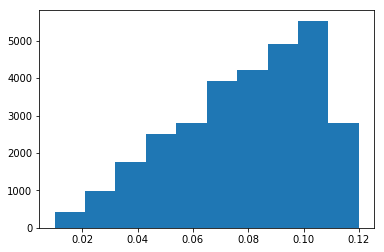

In [95]:
import matplotlib.pyplot as plt
plt.hist(y)

In [103]:
for yy in y:
    if yy == np.NAN: print('nna')

In [ ]:
from scipy.integrate import quad
from math import pi, exp, log
from scipy.stats import norm, triang, lognorm
import matplotlib.pyplot as plt

In [ ]:
#TODO determine 6 sigma for lognormal
s = 1
m = 0
#quad(lambda x: 1/np.sqrt(2*pi*s**2)*exp(-(x-m)**2/(2*s**2)),-3*s, 3*s)
quad(lambda x: 1/np.sqrt(2*pi*(s**2)*(x**2))*exp(-(log(x)-m)**2/(2*(s**2))),0,4*s)

In [ ]:
fig, ax = plt.subplots(1, 1)
x = samples_dt['19640']
c = 0.8
loc = 0
scale = 1
ax.plot(x, norm.pdf(x),'r-', lw=5, alpha=0.6, label='triang pdf')
plt.show()

## 3. Run LCI and LCIA with tech_params with new samples

In [ ]:
#Create new vector "amounts" of size n_params but with new sampled values
amount = lca.tech_params['amount']
score = np.zeros(N)
i = 0
for x in samples:
    if not (i % 50):
        print(i)
    amount[all_triang['i']] = x
    lca.tech_params['amount'] = amount
    lca.rebuild_technosphere_matrix(lca.tech_params['amount'])
    lca.redo_lci()
    lca.redo_lcia()
    score[i] = lca.score
    i += 1

In [ ]:
#Create new vector "amounts" of size n_params but with new sampled values
amount = lca.tech_params['amount']
score = np.zeros(N)
i = 0
amount[all_triang['i']] = samples[90]
lca.tech_params['amount'] = amount
lca.rebuild_technosphere_matrix(lca.tech_params['amount'])
lca.redo_lci()
lca.redo_lcia()
#score[i] = lca.score
#i += 1
lca.score

In [ ]:
samples[90]

In [ ]:
from scipy.stats.distributions import norm

In [ ]:
norm?

In [ ]:
score

In [ ]:
from matplotlib.pyplot import hist

In [ ]:
hist()

# [12.10.2018] Elementary effect method

In [ ]:
Si = morris.analyze(problem, X, Y, conf_level=0.95, print_to_console=True, num_levels=4, grid_jump=2)

In [ ]:
uncertain_params = lca.tech_params

def formulate_salib_problem(uncertain_params):
    
    stats_array_2_salib(uncertain_params)
    
    num_vars = len(uncertain_params)
    
    #Assign names to all tech_params according to their matrix position
    names = [str(x) for x in range(num_vars)]
    
    bounds = []
    
    return num_vars, names, bounds

In [ ]:
from math import exp, sqrt

In [ ]:
def stats_array_2_salib(vec):
    """
    Function that converts uncertainty info from stats_array format to salib format
    
    stats_array format: https://stats-arrays.readthedocs.io/en/latest/index.html#params-array
    salib format: https://github.com/SALib/SALib/blob/master/SALib/util/__init__.py
    """
    
    #IDs from stats_array
    id_uniform = 4
    id_triang = 5
    id_normal = 3
    id_lognorm = 2
    
    #Uniform
    if vec['uncertainty_type'] == id_uniform:
        dists = ['unif', vec['minimum'], vec['maximum']]
    #Triangular
    elif vec['uncertainty_type'] == id_triang:
        width = vec['maximum']-vec['minimum']
        peak = (vec['loc']-vec['minimum'])/float(width)
        dists = ['triang', width, peak, vec['minimum']]
    #Normal
    elif vec['uncertainty_type'] == id_normal:
        dists = ['norm', vec['loc'], vec['scale']]
    #Lognormal
    elif ['uncertainty_type'] == id_lognorm:
        m = vec['loc']   #mean of the underlying normal distribution
        s = vec['scale'] #std  of the underlying normal distribution
        ln_mean = exp(m + s**2/2)
        ln_std = sqrt((exp(s**2)-1)*exp(2*m+s**2))
        dists = ['lognorm', ln_mean, ln_std]
    else:
        dists = []
        
    return dists
    

In [ ]:
def stats_array_2_salib_all(vecs):
    for x in vecs:
        #Create a dictionary with tech_params and uncertainty info on them
        if x[6] ~= 0:
            

In [ ]:
stats_array_2_salib(lca.tech_params[16026])

In [ ]:
s = 0
for i in range(lca.tech_params.shape[0]):
    #Create a dictionary with tech_params and uncertainty info on them
    if lca.tech_params[i][5] == 5:
        s+=1
print(s)

In [ ]:
lca.tech_params[16026][]

# For the given demand vector run Monte Carlo simulations

In [ ]:
import stats_arrays as st

In [ ]:
#First local MC, only change A[1,2681]
for j in range(len(act_lci.tech_params)):
    if ((act_lci.tech_params[j]["row"]==1) and (act_lci.tech_params[j]["col"]==2681)):
        break
index = j
A_1_2681 = act_lci.tech_params[index]
#Specify distribution parameters (as they are given by ecoinvent)
A_1_2681_params = {key:value for (key,value) in zip(A_1_2681.dtype.names,A_1_2681)}

In [ ]:
#random number generator
A_1_2681_gen = st.MCRandomNumberGenerator(st.UncertaintyBase.from_dicts(A_1_2681_params))

In [ ]:
#number of MC simulations
N = 10
samples = np.zeros(N)
supply  = np.zeros((N,act_lci.inventory.shape[0]))
for i in range(N):
    samples[i] = next(A_1_2681_gen)
    temp = copy.deepcopy(act_lci.tech_params[:]["amount"])
    temp[index] = samples[i]
    act_lci.rebuild_technosphere_matrix(temp)
    act_lci.redo_lci()
    supply[i,:] = np.sum(act_lci.inventory,axis=1).A1

In [ ]:
#First order sensitivity indices
si_first = np.var(samples)/np.var(supply)
#si_total = 